# Fitting the Barnes Gyro relation using a latent fit

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import warnings
import matplotlib.gridspec as gridspec
import mystyle as ms
import pandas as pd

warnings.filterwarnings('ignore')

We'll add the uncertainty with a latent implementation.

$P = \tau^a \times b(B - V - c)^c$

where $P$ is rotation in days
$\tau$ is age (in Myr),
B-V are colour in magnitude,
the rest are free parameters


In [5]:
ati = pd.read_csv('../data/atium.csv',index_col=0)
ati = ati[np.isfinite(ati.P.values)]   #Exclude stars without results
ati = ati[ati.chainflag < 1]            #Exclude stars without well constrained results
print('We have {} stars'.format(len(ati)))

We have 49 stars


In [6]:
list(ati)

['KIC',
 'Teff',
 'age',
 'dnu',
 'eTeff',
 'ednu',
 'efeh',
 'enumax',
 'feh',
 'loage',
 'lomodlogg',
 'lomodmass',
 'lomodrad',
 'modlogg',
 'modmass',
 'modrad',
 'numax',
 'source',
 'upage',
 'upmodlogg',
 'upmodmass',
 'upmodrad',
 'G',
 'bprp',
 'flag',
 'nus*',
 'l_nus*',
 'u_nus*',
 'cosi',
 'l_cosi',
 'u_cosi',
 'i',
 'l_i',
 'u_i',
 'nus',
 'l_nus',
 'u_nus',
 'P',
 'l_P',
 'u_P',
 'vsini',
 'l_vsini',
 'u_vsini',
 'chainflag']

In [ ]:
period_obs = ati.P.values
sigma_p = (ati.loage.values + ati.upage.values)/2

age_obs = ati.age.values
sigma_age = (ati.l_P.values + ati.u_P.values)/2

bprp_obs = ati.P.values
sigma_p = (ati.l_P.values + ati.u_P.values)/2

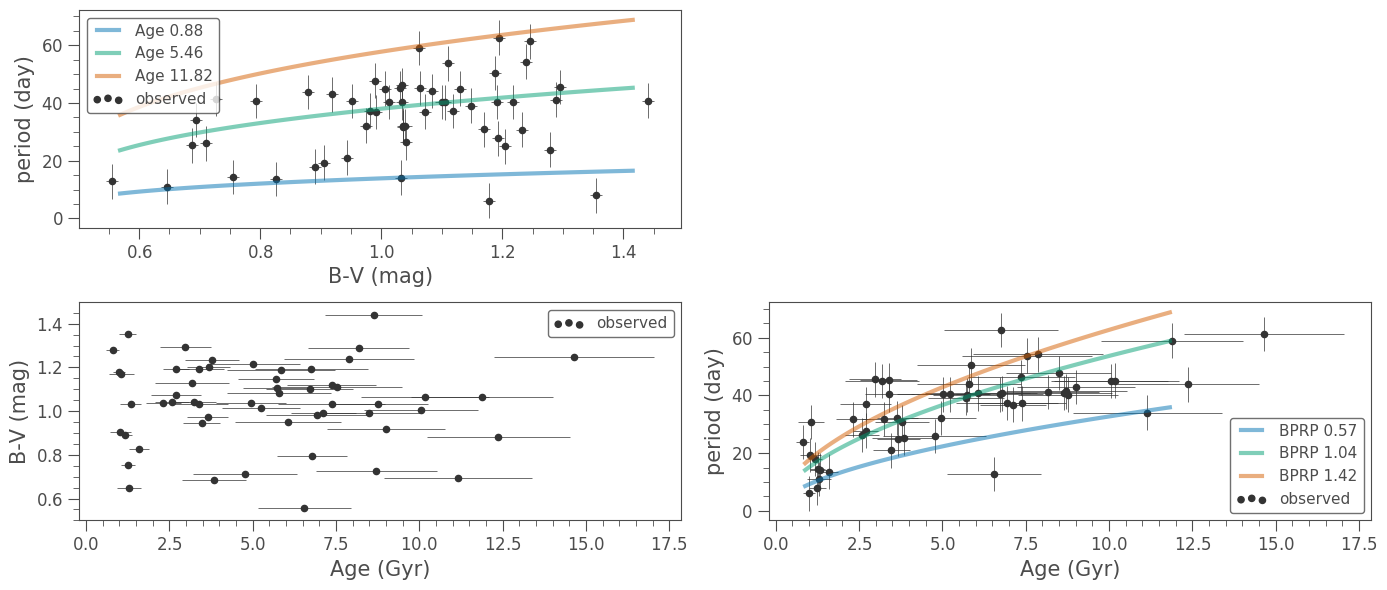

In [50]:
with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
    ax0.scatter(bprp_obs, period_obs,zorder=1, s=20, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('B-V (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
    ax1.scatter(age_obs, period_obs,zorder=1, s=20, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
    ax2.scatter(age_obs, bprp_obs,zorder=1, s=20, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('B-V (mag)')
    ax2.legend()    
    
    agex = np.linspace(age_true.min(), age_true.max(), 100)
    ax1.plot(agex, gyro(agex, bprp_true.min(), *angus), label='BPRP {:.2f}'.format(bprp_true.min()), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, np.mean(bprp_true), *angus), label='BPRP {:.2f}'.format(np.median(bprp_true)), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, bprp_true.max(), *angus), label='BPRP {:.2f}'.format(bprp_true.max()), 
             lw=3, alpha=.5)    
    ax1.legend()
    
    bprpx = np.linspace(bprp_true.min(), bprp_true.max(), 100)
    ax0.plot(bprpx, gyro(age_true.min(), bprpx, *angus), label='Age {:.2f}'.format(age_true.min()), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(np.mean(age_true), bprpx, *angus), label='Age {:.2f}'.format(np.median(age_true)), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(age_true.max(), bprpx, *angus), label='Age {:.2f}'.format(age_true.max()), 
             lw=3, alpha=.5)    
    ax0.legend()    
    
    fig.tight_layout()
    plt.show()

Now lets fit for Period using a latent parameter model

In [53]:
latentfit = '''
data {
    int<lower=1> N;
    real<lower=0> P[N];
    real<lower=0> sigma_p[N];
    
    real bprp[N];
    real<lower=0> sigma_bprp[N];
    
    real<lower=0> age[N];
    real<lower=0> sigma_age[N];
}
parameters {
    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> c;
    real<lower=0> d;
    
    real raw_bprp[N];
    real raw_age[N];
}
transformed parameters {
    real<lower=0> true_age[N];
    real true_bprp[N];
    
    for (n in 1:N){
        true_age[n] = sigma_age[n] * raw_age[n] + age[n];
        true_bprp[n] = sigma_bprp[n] * raw_bprp[n] + bprp[n];
    }
}
model {
    real mod[N];
    
    for (n in 1:N){
        mod[n] = (true_age[n]*1000)^a * b * (true_bprp[n] - c)^d;
    }
    
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    c ~ normal(0., 1.);
    d ~ normal(0., 1.);
    
    raw_bprp ~ std_normal(); // implies true_bprp ~ normal(bprp, sigma_bprp)
    raw_age ~ std_normal(); // implies true_age ~ normal(age, sigma_age)
    
    mod ~ normal(P, sigma_p);
}
'''
sm = pystan.StanModel(model_code = latentfit, model_name='latentfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL latentfit_2eb9e12a3a32a9d48d74d0ba9f139ee5 NOW.


In [54]:
data = {'N' : len(period_obs),
       'P' : period_obs,
       'sigma_p' : sigma_p,
       'bprp' : bprp_obs,
       'sigma_bprp' : sigma_bprp,
       'age' : age_obs,
       'sigma_age' : sigma_age}

init = {'a' : angus[0],
        'b' : angus[1],
        'c' : angus[2],
        'd' : angus[3],
        'true_age' : age_true,
        'true_bprp' : bprp_true}

In [55]:
fit = sm.sampling(data=data, iter=20000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [56]:
print(fit)

Inference for Stan model: latentfit_2eb9e12a3a32a9d48d74d0ba9f139ee5.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a               0.42  1.1e-3   0.04   0.36    0.4   0.42   0.45    0.5   1025    1.0
b               1.19    0.01   0.37   0.59   0.92   1.15   1.43    2.0   1003    1.0
c               0.37  7.6e-3   0.16   0.03   0.26   0.42   0.51   0.56    441   1.01
d               0.42    0.01   0.16   0.17    0.3   0.39   0.52   0.78    164   1.03
raw_bprp[1]    -0.06    0.05   1.02  -2.04  -0.78  -0.08   0.64   1.91    457   1.01
raw_bprp[2]     0.03    0.04    1.0   -1.9  -0.68   0.01   0.73   1.98    595   1.01
raw_bprp[3]     0.05    0.03    1.0  -1.91  -0.63   0.06   0.75   1.94    842    1.0
raw_bprp[4]    -0.08    0.04   1.01  -2.02   -0.8  -0.07   0.61   1.92    535    1.0
raw_bprp[5]     0.02    0.02   0.98   -1.9 

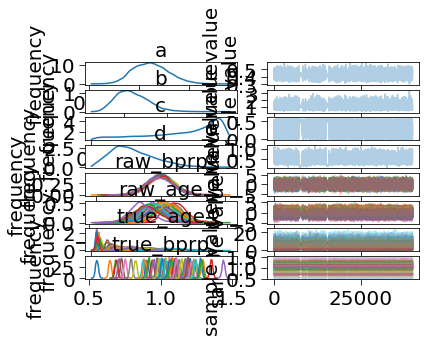

In [57]:
fit.plot()
plt.show()

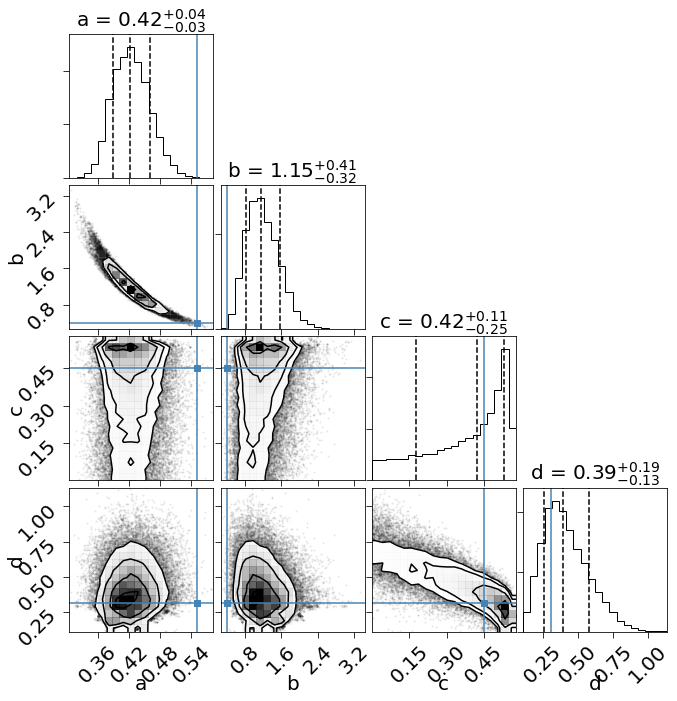

In [58]:
import corner
labels=['a','b','c','d']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, truths=angus,
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec
import mystyle as ms

gyrores = [np.median(fit[label]) for label in ['a','b','c','d']]

with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
    ax0.scatter(bprp_obs, period_obs,zorder=1, s=20, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('B-V (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
    ax1.scatter(age_obs, period_obs,zorder=1, s=20, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
    ax2.scatter(age_obs, bprp_obs,zorder=1, s=20, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('B-V (mag)')
    ax2.legend()    
    
    agex = np.linspace(age_true.min(), age_true.max(), 100)
    ax1.plot(agex, gyro(agex, bprp_true.min(), *gyrores), label='BPRP {:.2f}'.format(bprp_true.min()), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, np.mean(bprp_true), *gyrores), label='BPRP {:.2f}'.format(np.median(bprp_true)), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, bprp_true.max(), *gyrores), label='BPRP {:.2f}'.format(bprp_true.max()), 
             lw=3, alpha=.5)    
    ax1.legend()
    
    bprpx = np.linspace(bprp_true.min(), bprp_true.max(), 100)
    ax0.plot(bprpx, gyro(age_true.min(), bprpx, *gyrores), label='Age {:.2f}'.format(age_true.min()), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(np.mean(age_true), bprpx, *gyrores), label='Age {:.2f}'.format(np.median(age_true)), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(age_true.max(), bprpx, *gyrores), label='Age {:.2f}'.format(age_true.max()), 
             lw=3, alpha=.5)    
    ax0.legend()    
    
    fig.tight_layout()
    plt.show()

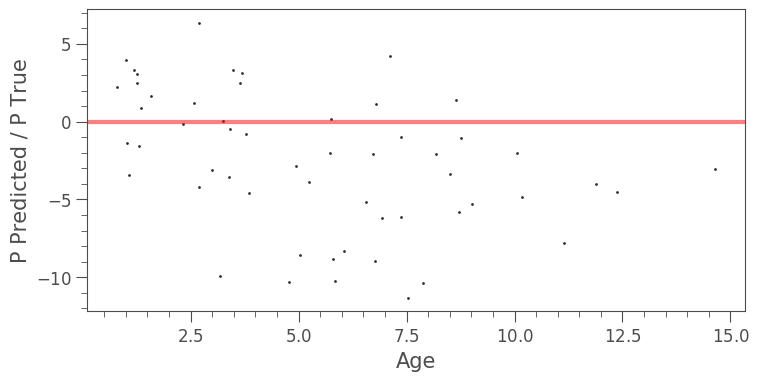

In [66]:
gyropred = gyro(age_obs, bprp_obs, *gyrores)
with plt.style.context(ms.ms):
    fig = plt.figure()
    ax= fig.gca()
    ax.scatter(age_obs, gyropred - period_true)
    ax.axhline(0., lw=3, c='r', alpha=.5)
    ax.set_ylabel('P Predicted / P True')
    ax.set_xlabel('Age')


### Notes

We don't recover the true values for $a, b, c, d$. Is this because the uncertainties are unrelated? Even a latent parameter model can't go beyond its uncertainties too far. Maybe they can't be reconciled.

It is worth noting that if I run with very small uncertainties and truth values we recover the correct $a, b, c, d$. So our model works as intended, at least!